# Dead Leaves - Synthetic Images Generation

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import

In [1]:
from multiprocessing import Pool
from dead_leave_generator import *
from utils import store_dl_disk

%load_ext autoreload
%autoreload 2

## CT Images Stats

In [2]:
ct_stat_results = np.load('data_stats_analysis/ct_stat_results.npz')

## Generation

Start by defining the number of image to generate and the amount core cpu have your machine to parallelize the generation.

In [3]:
# Number of core cpu your machine has
cpu_core = 50

# Total number of Dead Leaves images to compute. Note that we only compute 13'301 DL images since
# a test batch is not required. We test performance of models on CT.
nb_dl_images = 100  # 13301

### Pink Noised DL

Start generating Pink Noised Dead Leaves.

In [4]:
# Arguments for the Dead Leaves generation
dl_args = {
    'alpha': abs(ct_stat_results['alpha']-0.3),
    'r_min': 6, # 6
    'r_max': 512,  # 512
    'color_distribution': ct_stat_results['color_distribution'],
    'width': 512,
    'height': 512,
    'max_objects': 50000,  # 50k
    'noise_type': 'pink',
    'noise_var': 600,  #600
    'n': 2  # augmentation factor of DL images
}

# Creation of tuple to give to the Dead Leaves generator
nb_dl_images_per_cpu = int(nb_dl_images / cpu_core + 0.5)
infos = (nb_dl_images_per_cpu, dl_args)

# Compute the Dead Leaves images in parallel in each given core cpu
pool = Pool(cpu_core)
results_pink = pool.map(dead_leaves_generator, [infos for _ in range(cpu_core)])

# Concatenate the results from all the cores cpu
dead_leaves_pink = results_pink[0]
for result in results_pink[1:]:
    dead_leaves_pink.imgs += result.imgs
dead_leaves_pink.len = len(dead_leaves_pink.imgs)

And have a quick look at the generated images, by changing the idx parameter.

Radius min:  6
Radius max:  512
Alpha used:  1.9678
Number of images:  100
----------- idx: 0 -----------
Disk number:  1538
Width:  512
Height:  512
Radius mean:  25.307542262678805
Ratio drawn: 99.84%


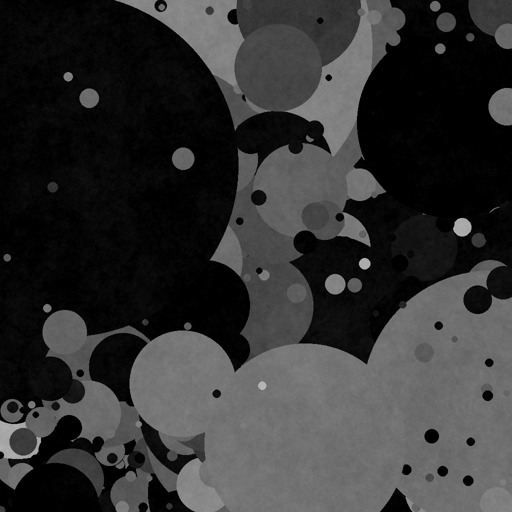

In [5]:
visualize_generation(dead_leaves=dead_leaves_pink, idx=0)

#### Statistical Overview

Look at different distribution of the generated images. We are trying to mimic the ones from CT images.

##### Color Distribution

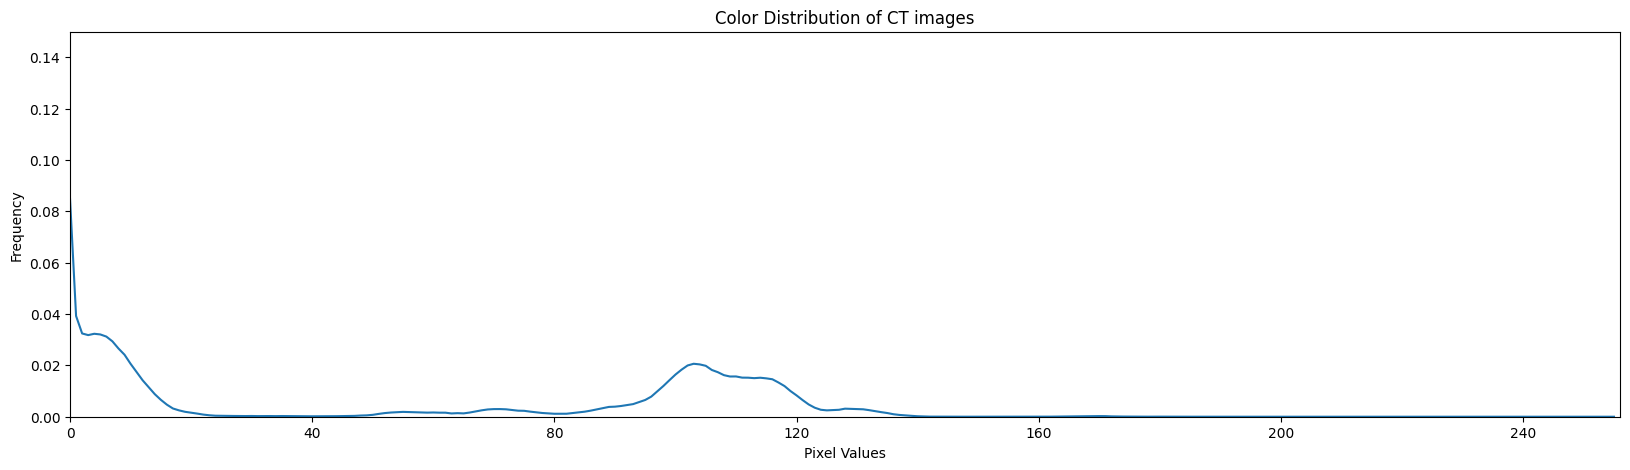

In [6]:
dl_pink_color_hist = dead_leaves_pink.color_histogram(plot=True)

##### Directional Gradient

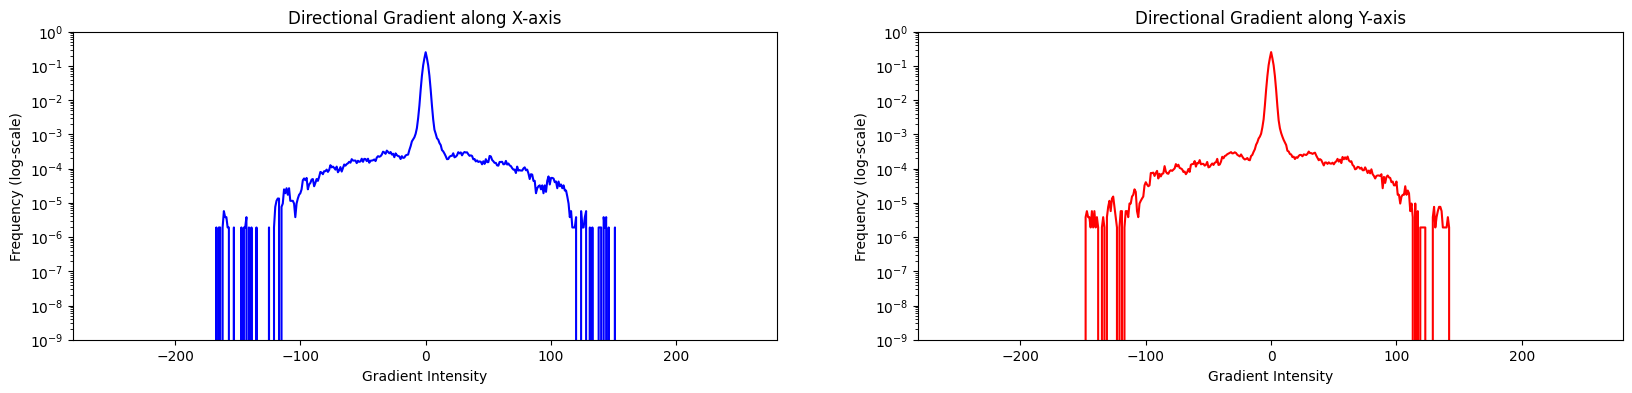

In [7]:
dl_pink_grad_dist_x, dl_pink_grad_dist_y, dl_pink_grad_intensity = dead_leaves_pink.directional_gradient(plot=True)

##### Fourier Analysis

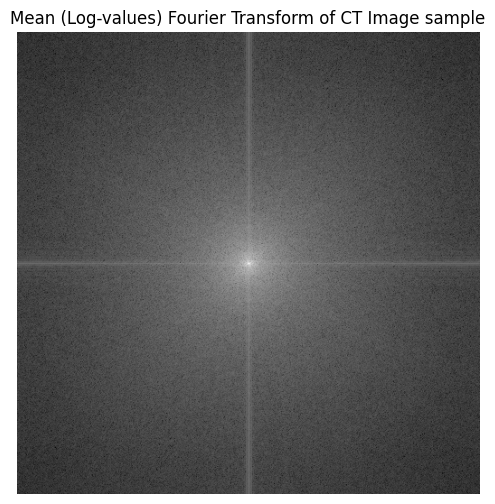

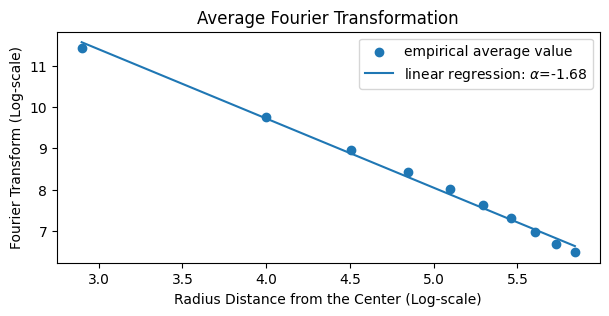

In [8]:
dl_pink_alpha = dead_leaves_pink.fourier_transform_analysis(plot=True)

### Brownian Noised DL

Start generating Brownian Noised Dead Leaves.

In [9]:
# Arguments for the Dead Leaves generation
dl_args = {
    'alpha': abs(ct_stat_results['alpha']-0.3),
    'r_min': 6,  # 6
    'r_max': 512,  # 512
    'color_distribution': ct_stat_results['color_distribution'],
    'width': 512,
    'height': 512,
    'max_objects': 50000,  # 50k
    'noise_type': 'brown',
    'noise_var': 6000,  #6k
    'n': 2  # augmentation factor of DL images,
}

# Creation of tuple to give to the Dead Leaves generator
nb_dl_images_per_cpu = int(nb_dl_images / cpu_core + 0.5)
infos = (nb_dl_images_per_cpu, dl_args)

# Compute the Dead Leaves images in parallel in each given core cpu
pool = Pool(cpu_core)
results_brown = pool.map(dead_leaves_generator, [infos for _ in range(cpu_core)])

# Concatenate the results from all the cores cpu
dead_leaves_brown = results_brown[0]
for result in results_brown[1:]:
    dead_leaves_brown.imgs += result.imgs
dead_leaves_brown.len = len(dead_leaves_brown.imgs)

And have a quick look at the generated images, by changing the idx parameter.

Radius min:  6
Radius max:  512
Alpha used:  1.9678
Number of images:  100
----------- idx: 0 -----------
Disk number:  1538
Width:  512
Height:  512
Radius mean:  25.307542262678805
Ratio drawn: 99.84%


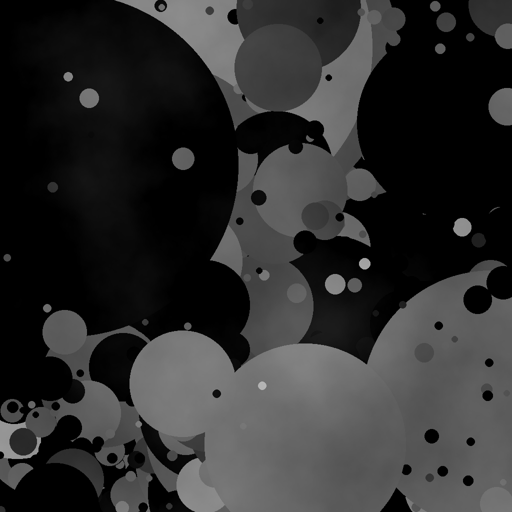

In [10]:
visualize_generation(dead_leaves=dead_leaves_brown, idx=0)

#### Statistical Overview

Look at different distribution of the generated images. We are trying to mimic the ones from CT images.

##### Color Distribution

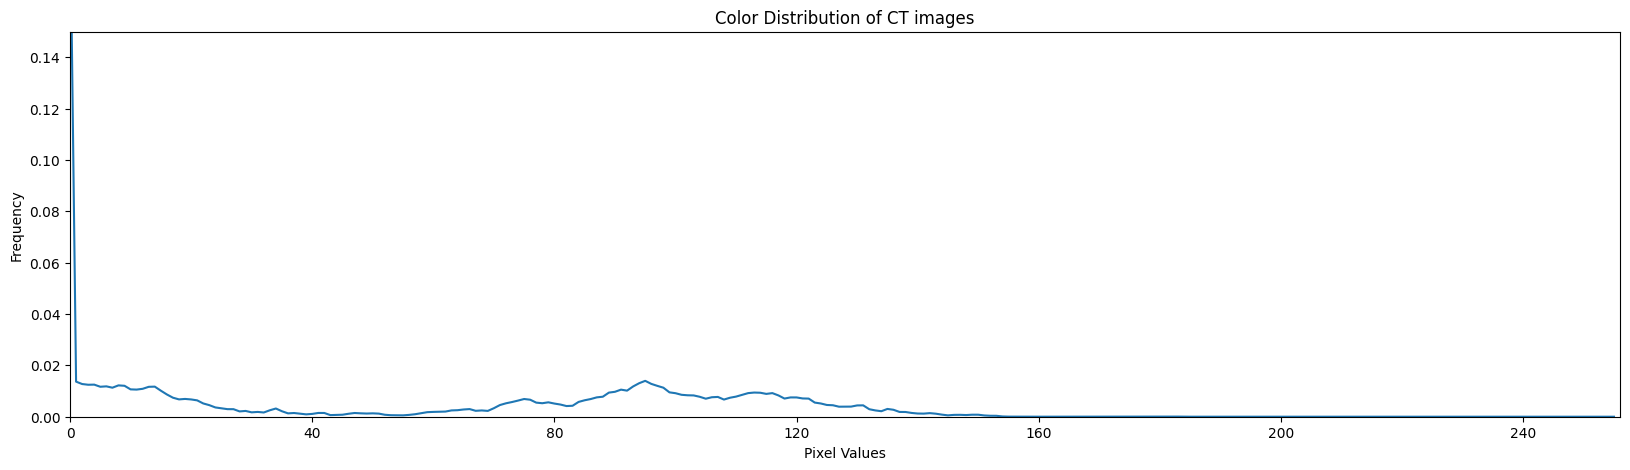

In [11]:
dl_brown_color_hist = dead_leaves_brown.color_histogram(plot=True)

##### Directional Gradient

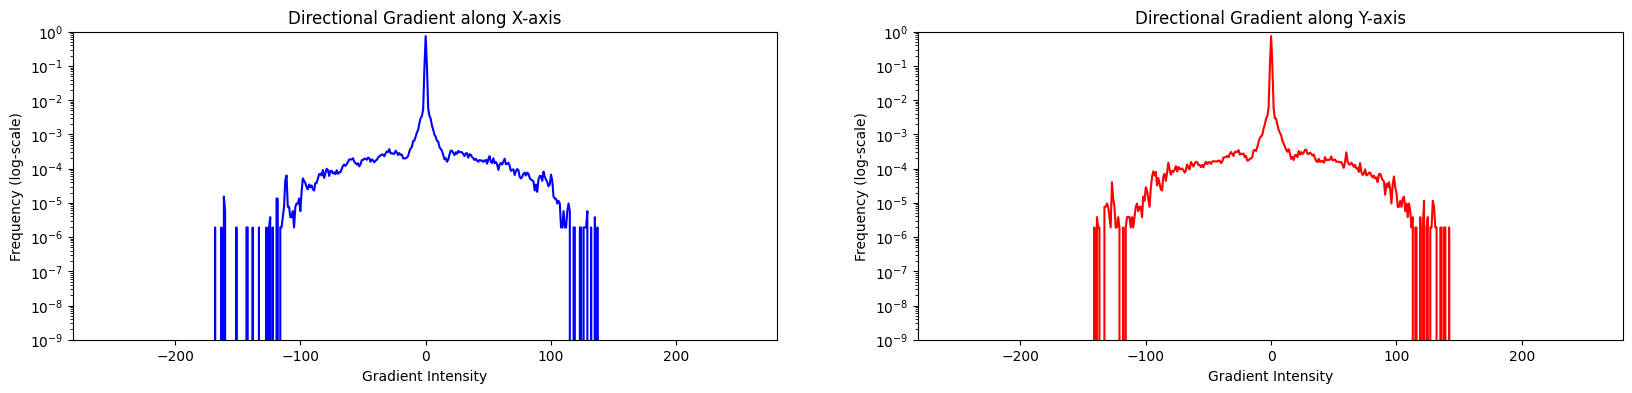

In [12]:
dl_brown_grad_dist_x, dl_brown_grad_dist_y, dl_brown_grad_intensity = dead_leaves_brown.directional_gradient(plot=True)

##### Fourier Analysis

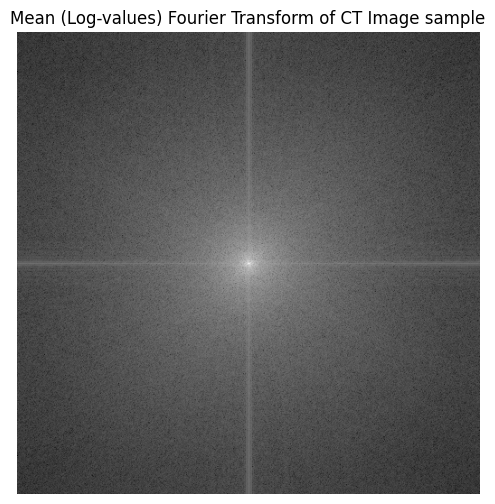

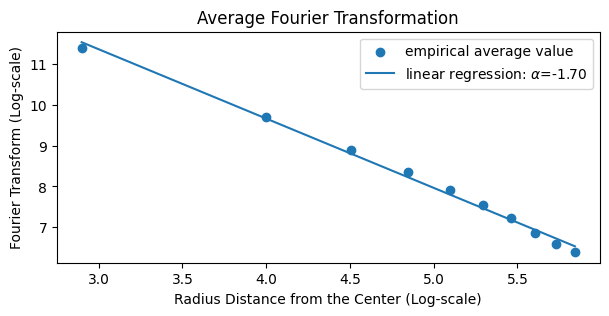

In [13]:
dl_brown_alpha = dead_leaves_brown.fourier_transform_analysis(plot=True)

## Store DL images

In [14]:
# Fix the path to store the dl images
path_pink = "data/train/dl_images_pink/"
path_brown = "data/train/dl_images_brown/"
 
# Store the image in disk
store_dl_disk(path_pink, dead_leaves_pink.imgs)
store_dl_disk(path_brown, dead_leaves_brown.imgs)

Writing generated Dead Leaves into disk:   0%|          | 0/100 [00:00<?, ?it/s]

Writing generated Dead Leaves into disk:   0%|          | 0/100 [00:00<?, ?it/s]

## Testing Cells

I let the testing cells to allow users try different parameters and understand their impact.

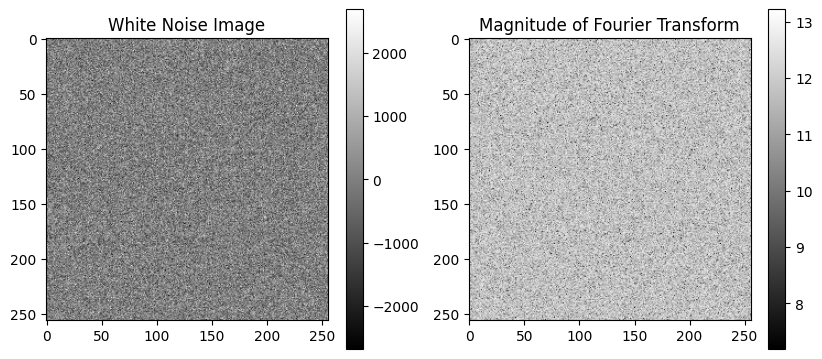

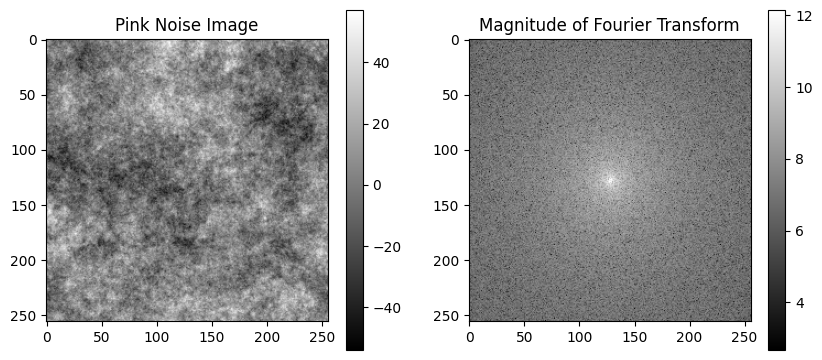

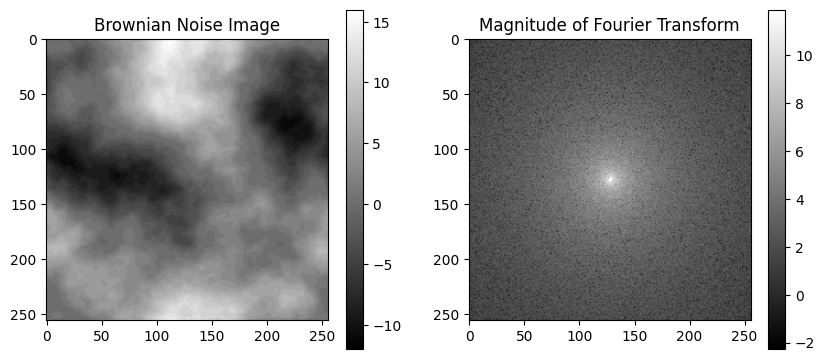

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/70085015/how-to-generate-2d-colored-noise

# Define the size of the image
image_size = 256

# Generate white noise image
whitenoise = np.random.normal(size=(256, 256)) * 600

# Compute 2D Fourier transform
ft_arr = np.fft.fftshift(np.fft.fft2(whitenoise))

_x, _y = np.mgrid[0:ft_arr.shape[0], 0:ft_arr.shape[1]]
f = np.hypot(_x - ft_arr.shape[0] / 2, _y - ft_arr.shape[1] / 2)
f[f == 0] = 1
# Pink noise
pink_ft_arr = np.nan_to_num(ft_arr / f, nan=0, posinf=0, neginf=0)
pinknoise = np.fft.ifft2(np.fft.ifftshift(pink_ft_arr)).real.astype(int)
# Brownian noise
f = f ** 2
brown_ft_arr = np.nan_to_num(ft_arr / f, nan=0, posinf=0, neginf=0)
brownnoise = np.fft.ifft2(np.fft.ifftshift(brown_ft_arr)).real.astype(int)

# Plot the whitenoise image
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 1)
plt.imshow(whitenoise, cmap='gray')
plt.title('White Noise Image')
plt.colorbar()

# Plot the magnitude of the Fourier transform
plt.subplot(3, 2, 2)
plt.imshow(np.log(np.abs(ft_arr)), cmap='gray')
plt.title('Magnitude of Fourier Transform')
plt.colorbar()

# Plot the pinknoise image
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 3)
plt.imshow(pinknoise, cmap='gray')
plt.title('Pink Noise Image')
plt.colorbar()

# Plot the magnitude of the Fourier transform
plt.subplot(3, 2, 4)
plt.imshow(np.log(np.abs(pink_ft_arr)), cmap='gray')
plt.title('Magnitude of Fourier Transform')
plt.colorbar()

# Plot the brownnoise image
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 5)
plt.imshow(brownnoise, cmap='gray')
plt.title('Brownian Noise Image')
plt.colorbar()

# Plot the magnitude of the Fourier transform
plt.subplot(3, 2, 6)
plt.imshow(np.log(np.abs(brown_ft_arr)), cmap='gray')
plt.title('Magnitude of Fourier Transform')
plt.colorbar()

plt.show()

Cell to show the possibility to add random gradient color.

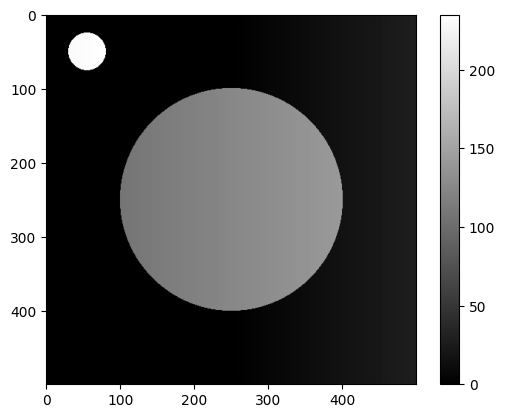

In [16]:
from dead_leave_generator import _gradient_layer

# Generate the empty/background image
image = Image.new("L", size=(500, 500), color=0)
draw = ImageDraw.Draw(image)

draw.ellipse(xy=(100, 100, 400, 400),
             fill=125)

draw.ellipse(xy=(30, 25, 80, 75),
             fill=256)

grad = _gradient_layer(image=image)

plt.imshow(grad, cmap='grey')
plt.colorbar()
plt.show()